# 프로젝트 : 카메라 스티커앱 만들기 첫걸음

**카메라 어플에서 흔히 볼 수 있는 스티커 기능을 만들어보는 차례입니다.  
시작부터 재미있을 것 같아 기대가 됩니다. 진심으로요.**

## 1. 데이터 준비하기
- 이미지 불러오기

## 2. 이미지 속 얼굴 확인하기
- 얼굴 인식하기
- 이목구비 찾기
- 스티커를 넣을 좌표 찾기

## 3. 스티커 적용하기
- 스티커 불러오기
- 스티커 간단하게 씌워보기
- 스티커 정확하게 씌워보기

## 4. 스티커 적용 함수 만들기

- - -
### 1. 데이터 준비하기
- 이미지 불러오기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os # 환경 변수나 디렉터리, 파일 등의 OS 자원을 제어할 수 있게 해주는 모듈
import cv2 # OpenCV라이브러리 → 컴퓨터 비전 관련 프로그래밍을 쉽게 할 수 있도록 도와주는 라이브러리
import matplotlib.pyplot as plt # 다양한 데이터를 많은 방법으로 도식화 할 수 있도록 하는 라이브러리
import numpy as np # 다차원 배열을 쉽게 처리하고 효율적으로 사용할 수 있도록 하는 라이브러리
import dlib # 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리 

필요한 모듈을 불러오고 시작합니다.

In [3]:
my_image_path = '/content/drive/MyDrive/Colab Notebooks/exp/Pictures/image.png' # 본인 이미지가 있는 경로를 가지고 온다.
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다

제 프로젝트를 봐주시는 분들께 공개될 셀카입니다. 👀

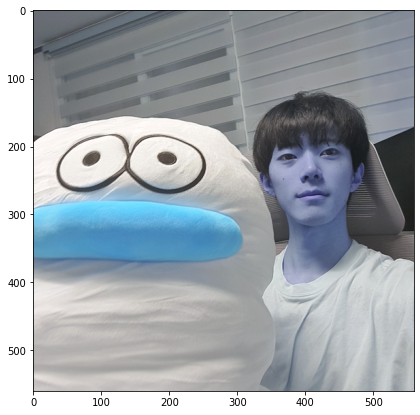

In [4]:
plt.rcParams['figure.figsize'] = 7, 7 # 그래프 기본 사이즈 (7, 7)
plt.imshow(img_bgr) # 이미지를 출력하기 위해 출력할 이미지를 올려준다. (실제 출력은 하지 않음)
plt.show() # 이미지를 출력해준다. (실제 출력)

으악 이게 뭐야

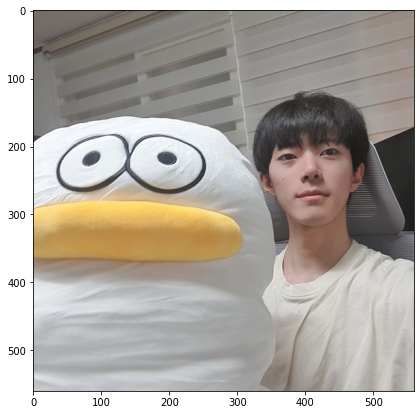

In [5]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb) # 이미지 실제 출력하기 위해 이미지를 올려줌 (원하는 사이즈의 픽셀을 원하는 색으로 채워서 만든 그림이라고 합니다.)
plt.show() # 이미지 실제 출력

맞다 RGB 변환 깜빡했습니다. 마냥 복붙하다보니..

그런데 여기서 헷갈릴까봐(제가요) 정리를 하고 가겠습니다.

`img_bgr`은 스머프화된 제 사진이 되겠구요.  
`img_show`는 튜닝이 되지 않은 원본을 남겨놓기 위해 출력용 및 테스트 목적으로 복사해둔겁니다.  
`img_rgb`는 bgr 순서를 rgb 순서로 바꿔서 정상적인 모습으로 출력되는 사진이 되겠습니다.

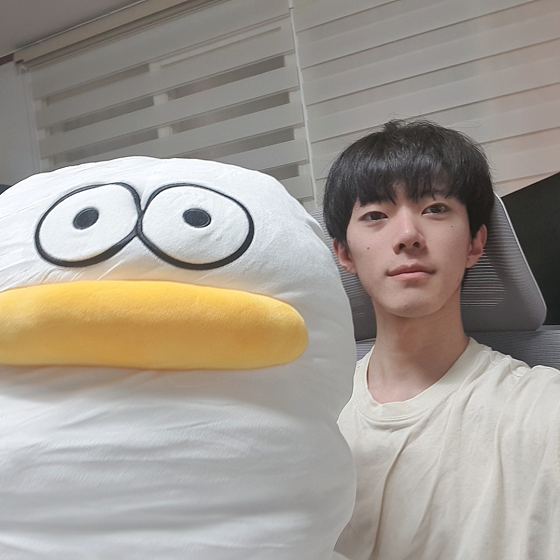

먼저 사진의 눈코입을 인식해서 이것이 사람 얼굴인가(?), 사람 얼굴이면 위치는 어디인가를 찾는 코드를 만들겠습니다.

하는 김에 옆에 있는 오둥이도 얼굴로 인식을 할까 확인해보겠습니다.

- - -
### 2. 이미지 속 얼굴 확인하기
- 얼굴 인식하기

In [6]:
detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기를 반환

dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

dlib_rects

rectangles[[(339, 182) (468, 311)]]

얼굴을 인식해주는 `dlib` 모듈의 `get_frontal_face_detector()` 라이브러리를 불러와주고 사진 속 제 얼굴을 인식시켜봤습니다.

`[(339, 182) (468, 311)]`의 값이 출력됐는데, 첫 번째 튜플은 (x의 최솟값 좌표, y의 최솟값 좌표), 두 번째 튜플은 (x의 최댓값 좌표, y의 최댓값 좌표)가 되겠군요.

그런데 여기서 각 튜플 사이에 `,`가 존재하지 않습니다. 때문에 이건 시퀀스 자료형이 아닐겁니다.

In [7]:
try:
    print(dlib_rects[0][0])
except:
    print('출력 불가')

출력 불가


실제로 `dlib_rects[0][0]`를 출력하라 하면 오류가 발생합니다.

그리고 사진에 있는 얼굴이 만약 여러 개였거나 오둥이의 얼굴도 인식했다면

인식한 얼굴의 수 만큼 두 쌍의 튜플들이 생성되겠지만 위와 같은 이유로 1차원 리스트 형태를 유지하겠죠.  
> *ex)* `rectangles[[(339, 182) (468, 311)], [(37, 171) (288, 389)]]`

    (37, 171) (288, 389)는 그냥 직접 어림잡아본 임의의 좌표값입니다.

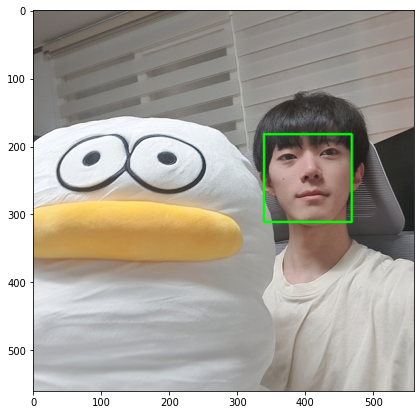

In [8]:
for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

하지만 `.left() .top() .right() .bottom()` 등의 메서드를 이용하면 각각의 좌표를 따로 불러올 수 있습니다.

노드에서 가져온 코드라 반복문으로 되어있지만 저처럼 얼굴이 하나인 사진만을 사용한다면 꼭 반복문으로 불러올 필요는 없겠습니다.



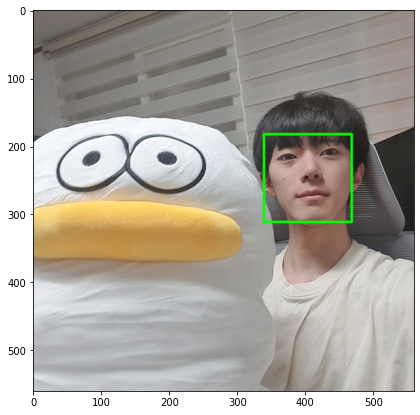

In [9]:
l = dlib_rects[0].left() # 왼쪽
t = dlib_rects[0].top() # 위쪽
r = dlib_rects[0].right() # 오른쪽
b = dlib_rects[0].bottom() # 아래쪽

cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

반복문을 사용하지 않는다면 이런 코드가 되겠습니다. 결국은 인덱싱을 이용해야 하니 그냥 반복문을 사용하는 것을 추천드립니다.

`cv2.rectangle`의 첫 번째 인자는 적용하려는 이미지가 되겠고, 두 번째 인자는 최소 x좌표값과 y좌표값을, 세 번째 인자는 최대 x좌표값과 y좌표값을 튜플로 받는 것 같습니다.

튜플로 묶어만 준다면 굳이 x와 y를 따로 나누지 않고 최소 좌표값과 최대 좌표값 두 가지로만 나눠서 각 꼭짓점을 수직, 수평선으로 연결만 해주면 사각형이 탄생합니다.  
> `(l,t)`를 풀어서 말하면 **'왼쪽 위'**가 되고, `(r,b)`도 그냥 **'오른쪽 아래'**가 되겠습니다.

네 번째 인자는 BGR값입니다. RGB값 아닙니다.

`(B:0, G:255, R:0)`을 해서 녹색이었는데, (255,255,0)을 해서 연청색을 만들어보겠습니다.

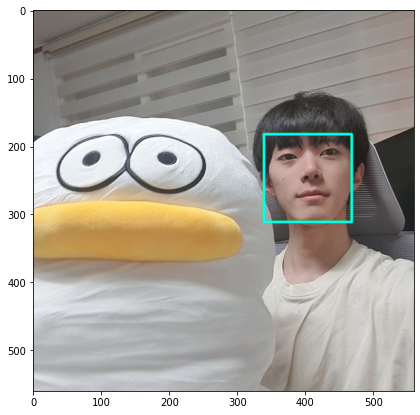

In [10]:
sample_image = img_show.copy() # ※cv2.rectangle은 실행할 때마다 추가된 사각형이 이미지 데이터에 그대로 적용되기 때문에 복사본을 준비해서 실험해보겠습니다.※

cv2.rectangle(sample_image, (l,t), (r,b), (255,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

다섯 번째 인자는 그려지는 선의 두께입니다. `2`에서 `10`으로 수정하고 확인해보겠습니다.  
> 픽셀값으로 받기 때문에 이미지의 크기를 참고해서 설정하시면 될 것 같습니다.  
> `-1`의 값을 주면 사각형의 내부가 전부 칠해집니다.

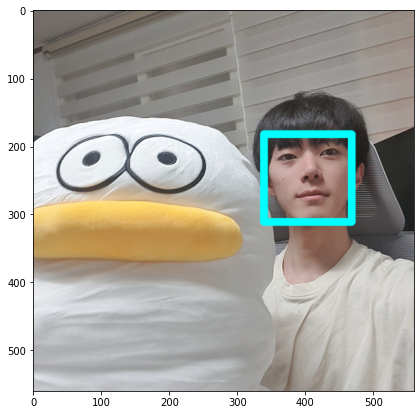

In [11]:
cv2.rectangle(sample_image, (l,t), (r,b), (255,255,0), 10, lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

선이 두꺼워졌습니다.

image.width : 560
image.height : 560
thickness : 28


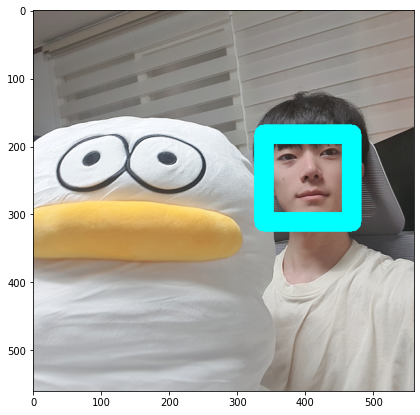

In [12]:
# 달라지는 이미지의 크기에 맞춰 비율을 계산하려면?

width, height = sample_image.shape[1], sample_image.shape[0]

thickness = min(width, height) // 20   # 가로와 세로 중 낮은 사이즈를 기준으로 이미지의 1/20 크기를 두께로 지정

print(f'image.width : {width}', f'image.height : {height}', f'thickness : {thickness}', sep='\n')

cv2.rectangle(sample_image, (l,t), (r,b), (255,255,0), thickness, lineType=cv2.LINE_4)

img_show_rgb = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

임의로 지어냈던 좌표값`(37, 171) (288, 389)`으로 오둥이한테도 사각형을 씌워보겠습니다.

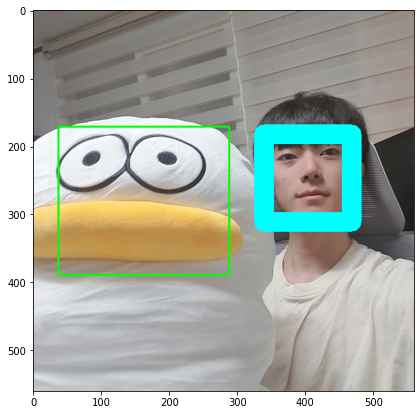

In [13]:
cv2.rectangle(sample_image, (37, 171), (288, 389), (0,255,0), 2, lineType=cv2.LINE_4)

img_show_rgb = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

오! 얼추 들어맞았습니다.

여기서 짚고 넘어가야 할 것은 `dlib.get_frontal_face_detector()`는 얼굴을 인식하고 얼굴로 포함되는 공간의 최소 좌표와 최대 좌표만을 찾아주고,

해당 좌표에 사각형을 그려주는 것은 `cv2.rectangle`에서 이루어졌다는 겁니다.

`dlib.get_frontal_face_detector()`를 사용해 얼굴 좌표를 얻고 그 좌표에 맞게 사각형을 그리는 것이 아닌 자르기를 사용할 수도 있겠죠?

- - -
### 2. 이미지 속 얼굴 확인하기
- 이목구비 찾기

In [14]:
model_path = '/content/drive/MyDrive/Colab Notebooks/exp/Pictures/shape_predictor_68_face_landmarks.dat'
    # 저장한 landmark 모델의 주소를 model_path 변수에 저장
landmark_predictor = dlib.shape_predictor(model_path)
    # dlib 라이브러리의 shape_predictor 함수를 이용하여 모델을 불러옴
    # landmark_predictor는 RGB이미지와 dlib.rectangle를 입력 받고 dlib.full_object_detection를 반환
    # dlib.rectangle: 내부를 예측하는 박스
    # dlib.full_object_detection: 각 구성 요소의 위치와, 이미지 상의 객체의 위치를 나타냄
    
landmark_predictor

weight file을 `dlib.shape_predictor`로 불러와서 `landmark_predictor`라는 객체를 생성했습니다.

이미지 속 얼굴의 윤곽과 이목구비의 포인트를 68개로 나눠서 검출해주는 라이브러리입니다.

In [15]:
points = landmark_predictor(img_rgb, dlib_rects[0])

points.parts()

points[(343, 227), (346, 242), (350, 257), (353, 271), (359, 285), (368, 298), (380, 308), (395, 315), (413, 316), (430, 314), (444, 306), (455, 295), (463, 281), (467, 266), (469, 250), (470, 234), (470, 218), (352, 209), (358, 198), (368, 191), (382, 188), (395, 190), (409, 188), (422, 183), (436, 183), (449, 187), (457, 197), (405, 207), (406, 215), (407, 224), (408, 234), (397, 251), (403, 251), (409, 251), (415, 250), (420, 248), (364, 219), (370, 213), (379, 212), (387, 216), (380, 219), (371, 220), (423, 212), (431, 206), (439, 206), (446, 210), (440, 213), (432, 213), (389, 276), (396, 269), (404, 264), (410, 265), (416, 263), (424, 266), (434, 272), (426, 277), (419, 279), (412, 280), (406, 280), (398, 279), (392, 275), (404, 272), (410, 272), (417, 270), (431, 272), (417, 271), (411, 272), (405, 272)]

rgb 순서로 바꾼 이미지(`img.rgb`)와 생성됐던 얼굴 좌표 (`[(339, 182) (468, 311)]`)를 `landmark_predictor`에 입력해 `points`에 담습니다.

`point.parts()`를 불러오면 얼굴의 이목구비 포인트로 총 68개의 튜플이 담긴 리스트를 가져옵니다.

가져온 weight file의 이목구비 포인트는 이렇습니다.

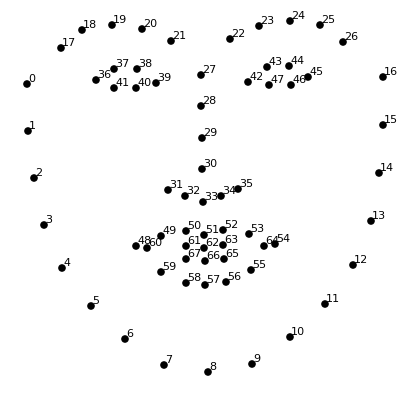

In [16]:
print(points.parts()[0])
print(points.parts()[0].x)
print(points.parts()[0].y)

(343, 227)
343
227


좌표들은 인덱싱이나 슬라이싱을 사용할 수 있고, 좌표 내용은 `.x`와 `.y`로 하나씩 불러올 수도 있습니다.

저는 잠시 코드를 살펴보기 위해 얼굴이 하나인 이미지를 기준으로 코드를 작성했는데요.

실제로 활용할 수 있게 얼굴이 여러 개여도 작동할 수 있도록 코드를 작성하려면 반복문을 이용하고

인식된 얼굴을 모두 한 번에 관리하려면 인식한 얼굴의 인덱스에 맞게 리스트에 넣어주는 과정을 거쳐야 합니다.

In [17]:
list_landmarks = []
    # 랜드마크의 위치를 저장할 list 생성    

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
# face landmark 좌표를 저장해둡니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
        # 모든 landmark의 위치정보를 points 변수에 저장
    list_landmarks.append(list(points.parts()))
        # list_landmarks에 랜드마크 리스트를 저장

print(len(list_landmarks))
print(len(list_landmarks[0]))
print(list_landmarks[0][0])
print(list_landmarks[0][0].x)
print(list_landmarks[0][0].y)
    # 얼굴이 n개인 경우 list_landmarks는 n개의 원소를 갖고
    # 각 원소는 68개의 랜드마크 위치가 나열된 list 
    # list_landmarks의 원소가 1개이므로 list_landmarks[1]을 호출하면 IndexError가 발생

1
68
(343, 227)
343
227


`for dlib_rect in dlib_rects:` 반복문을 이용해 인식한 얼굴 좌표들을 차례대로 불러와야겠구요.

반복문이 반복될 때마다 갱신되는 `points`를 리스트에 차례대로 담아주면

`list_landmarks[0]`을 하면 첫 번째 얼굴의 이목구비 포인트들을 가져오고,  
`list_landmarks[1]`을 하면 두 번째 얼굴의 이목구비 포인트들을 가져오는 2차원 리스트가 생성됩니다.

    각 튜플의 x값과 y값은 아직 인덱싱 또는 슬라이싱을 할 수 없습니다.
    위처럼 .x와 .y를 통해 불러와야 하는데요. 이후에 시퀀스 형태로 접근해야 할 때 p = (p.x, p.y)로 변환을 해주면 됩니다.
    LMS의 예제에서는 list_landmarks를 생성하면서 미리 변환을 했지만 이렇게 해도 된다라는 것을 보여드리려 조금 다르게 작성해봤습니다.

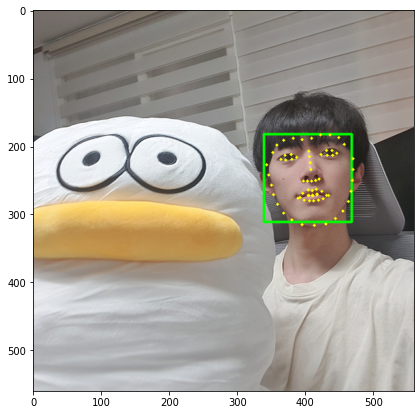

In [18]:
# list_landmarks의 원소가 1개이므로 아래 반복문은 한번만 실행됨
for landmark in list_landmarks:
    for point in landmark:
        point = (point.x, point.y) # 시퀀스 형태로 바꿔줍니다. LMS의 내용과는 살짝 다릅니다.
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
            # cv2.circle: OpenCV의 원을 그리는 함수
            # img_show 이미지 위 각각의 point에
            # 크기가 2이고 (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
            # (마지막 인수가 자연수라면 그만큼의 두께의 선으로 원이 그려짐)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB) # RGB 이미지로 전환
plt.imshow(img_show_rgb)
plt.show()

여기서 또 알아야 할 것은 `dlib.shape_predictor()` 역시 좌표만 검출해줄 뿐

이목구비 포인트에 직접 마크를 추가하는 것은 `cv2.circle()`의 역할이라는 겁니다.😝

사실 당연한겁니다. 고양이 수염을 추가하는데 얼굴에 점들이 생겨나면 안되잖아요?

- - -
### 2. 이미지 속 얼굴 확인하기
- 스티커를 넣을 좌표 찾기

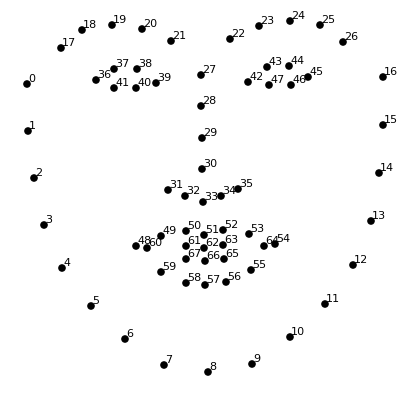

In [19]:
# zip() : 두 그룹의 데이터를 서로 엮어주는 파이썬의 내장 함수
# dlib_rects와 list_landmarks 데이터를 엮어 주었음
# dlib_rects : 얼굴 영역을 저장하고 있는 값
# list_landmarks : 68개의 랜드마크 값 저장(이목구비 위치(x,y))

for dlib_rect, landmark in zip(dlib_rects, list_landmarks): # 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
    print(landmark[30]) # 코의 index는 30 입니다
    x = landmark[30].x # 이미지에서 코 부위의 x값
    y = landmark[30].y - dlib_rect.height()//2 # 이미지에서 코 부위의 y값 - 얼굴 영역의 세로를 차지하는 픽셀의 수//2
    w = h = dlib_rect.width() # 얼굴 영역의 가로를 차지하는 픽셀의 수
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(408, 234)
(x,y) : (408,169)
(w,h) : (130,130)


이건 LMS에서 보여준 예제입니다. 예제는 코에 그리는 고양이 수염이 아닌 머리에 씌우는 왕관이기도 했고,

얼굴 영역 좌표를 이용해 머리에 해당하는 위치를 구하려 했기 때문에 `zip(dlib_rects, list_landmarks)`을 사용했는데요.

저는 코의 좌표만 필요하기 때문에 아직 얼굴 영역 사이즈를 활용할 필요는 없습니다.

하지만 얼굴이 여러 개일 수도 있기 때문에 반복문으로 실행하기는 해야합니다.

    코드를 집중해서 보신 분은 눈치 채셨겠지만 원래 LMS 예제의 코드 x = landmark[30][0], [1] 부분을 x = landmark[30].x, .y로 수정했습니다.

In [20]:
face = list_landmarks[0]

print(face[33]) # 코 끝의 index는 33 입니다
x = face[33].x
y = face[33].y
print ('(x,y) : (%d,%d)'%(x,y))

(409, 251)
(x,y) : (409,251)


반복문을 사용하지 않고 코드를 직관적이게 본다면 이렇게 되겠죠.

코 위에 대면 위치가 부자연스러울까봐 코 끝의 인덱스 33으로 변경했습니다.

예제의 코드는 얼굴 영역의 가로와 세로를 이용해 적절한 스티커 사이즈와 정확한 위치를 구하려고 코드가 복잡해보였을 수 있는데요.

제가 쓸 코드는 가로와 세로 사이즈를 지금은 제외하고 참고만 했다가 고양이 수염을 씌울 때 구해보겠습니다.

- - -
### 3. 스티커 적용하기
- 스티커 불러오기

(512, 512, 3)


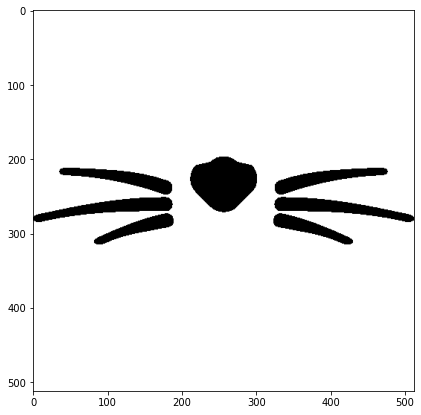

In [21]:
sticker_path = '/content/drive/MyDrive/Colab Notebooks/exp/Pictures/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다 // cv2.imread(이미지 경로) → image객체 행렬을 반환
print(img_sticker.shape)
plt.imshow(img_sticker)
plt.show()

제가 사용할 고양이 수염 이미지입니다. 512x512 픽셀에 꽉차게 들어가있군요.

이제 이걸 어떻게 넣어야 코에 딱 들어갈지 생각해봅시다.

간편하게 하는 방법은 고양이 수염을 얼굴 영역 사이즈와 같게 크기를 조정하고 x와 y좌표에 스티커 사이즈의 절반 만큼을 빼는 방법이 되겠구요.

정확하고 실용적이게 하는 방법은 고양이 수염을 분할해서 가운데를 정확히 코 끝의 좌표와 일치시키고 사이즈를 조정하는 것이 되겠죠.

4분할을 해주면 적어도 상하좌우의 각도 정도는 대응이 가능해질 겁니다.

- - -
### 3. 스티커 적용하기
- 스티커 간단하게 씌워보기

간편하게 하는 방법을 먼저 작성해보겠습니다.

(130, 130, 3)


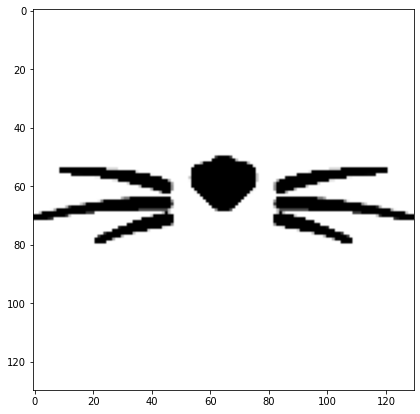

In [22]:
w = dlib_rects[0].width()
h = dlib_rects[0].height()

img_sticker_resize = cv2.resize(img_sticker, (w, h))
print(img_sticker_resize.shape)
plt.imshow(img_sticker_resize)
plt.show()

얼굴 영역과 동일한 크기로 리사이즈해줍니다.

In [23]:
refined_x = x - w//2
refined_y = y - h//2

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (344,186)


한 눈에 봤을 때 코에 들어갈 부분이 스티커의 가운데이기 때문에 코의 x와 y좌표에서 이미지의 절반 만큼을 뺀 값을 이미지의 시작점으로 지정하겠습니다.

In [24]:
if refined_x < 0: 
    img_sticker_resize = img_sticker_resize[:, -refined_x:]
    refined_x = 0

if refined_y < 0:
    img_sticker_resize = img_sticker_resize[-refined_y:, :]
    refined_y = 0

만약에 코가 얼굴의 위쪽에 위치하거나 왼쪽에 위치할 경우를 대비해 시작점이 음수를 가지면 0의 좌표부터 시작하도록 오류를 방지하는 코드입니다.

여기서 신기한 것은 `-x` 또는 `-y`를 이용해 음수를 깔끔하게 제거했다는거죠.

x의 경우 두 번째 슬라이싱으로 열을 다루면서 `[:, -x:]`을 했습니다. 만약 x가 음수라면 -x는 양수가 되겠죠.

리스트 `[-2, -1, 0, 1, 2]`가 있었는데 -2의 -는 2가 되므로 `[2:]`를 하면 `[0, 1, 2]`가 되는겁니다.

y는 첫 번째 슬라이싱으로 행을 다뤄야 해서 `[-y:, :]`가 되겠습니다.

조건문으로 음수일 때만 실행하게 하는 것도 잊지 말아야 하겠구요.

(130, 130, 3)


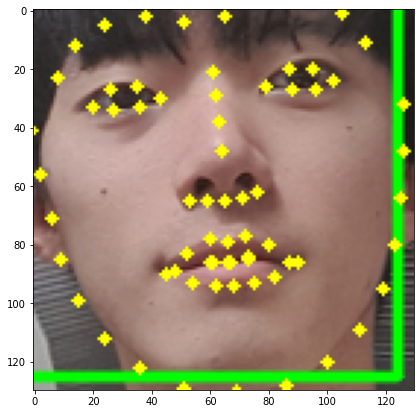

In [25]:
sticker_area = img_show[refined_y:refined_y + img_sticker_resize.shape[0], refined_x:refined_x + img_sticker_resize.shape[1]]
print(sticker_area.shape)

plt.imshow(cv2.cvtColor(sticker_area, cv2.COLOR_BGR2RGB))
plt.show()

간단한 슬라이싱을 이용해 시작점을 기준으로 스티커의 사이즈에 맞게 자른 이미지입니다. 여기에 그대로 스티커를 올리게 될겁니다.

슬라이싱은 **y좌표(행)**부터 시작해야 한다는 것에 유의해야 합니다.

In [26]:
img_sample = img_show.copy() # 다른 방법도 실행할 예정이여서 원본에 적용되지 않게 샘플을 복사하겠습니다.

img_sample[refined_y:refined_y+img_sticker_resize.shape[0], refined_x:refined_x+img_sticker_resize.shape[1]] = \
    np.where(img_sticker_resize==255, sticker_area, img_sticker_resize).astype(np.uint8)

물론 그냥 올리면 안되구요. `np.where`을 이용해 스티커(`img_sticker_resize`)가 255가 되는 부분.  
즉, 스티커의 하얀 부분은 원본(`sticker_area`)의 값을 넣고

그렇지 않은 부분은 스티커 이미지의 값을 채워 넣겠다 하는 코드입니다.

적용하려는 이미지와 스티커가 서로 사이즈가 다르니 적용하려는 부분을 슬라이싱을 해주고 실행합니다.

    예제에서는 0을 썼는데 저는 255을 써야 정상적으로 흰 부분이 없어졌습니다. 이 부분에 대해선 무슨 차이가 있었던건지 잘 모르겠네요.

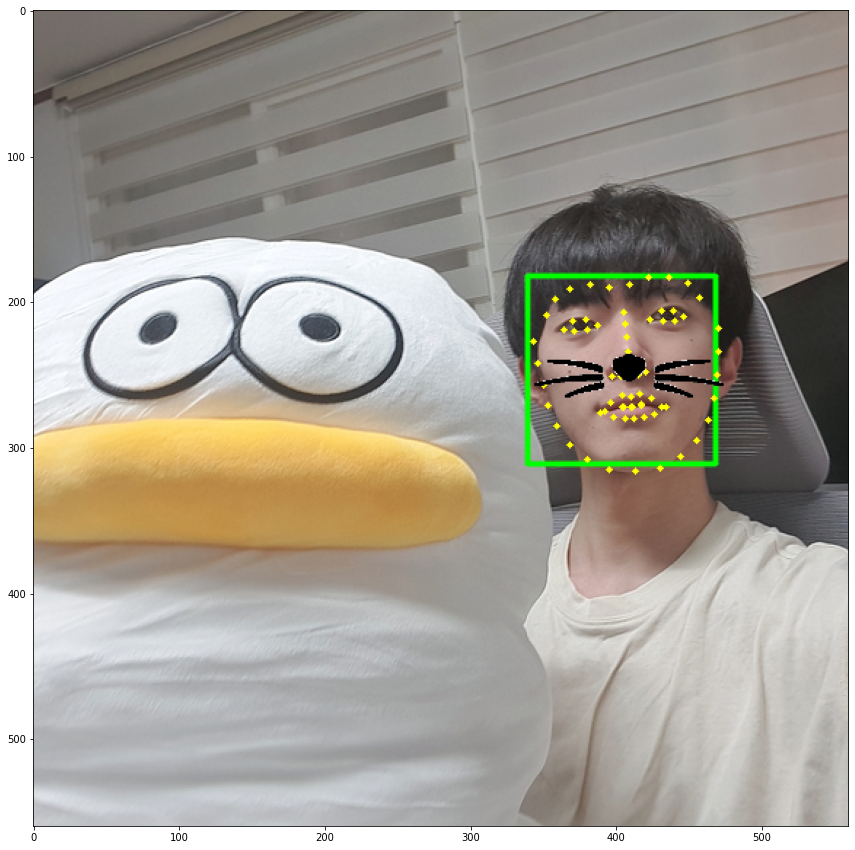

In [27]:
plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(img_sample, cv2.COLOR_BGR2RGB))
plt.show()

결과물입니다. 과정이 간단하기는 했으나 코에 정확히 들어갔다기 보단 조금 밑에 내려와있는 느낌이고

무엇보다 각도가 없이 항상 정면 느낌의 스티커라는겁니다. 위 사진은 제가 정면에서 찍었으니 별 문제 없어보일 수 있지만

옆모습으로 촬영했으면 아마 이질감이 느껴졌을겁니다.

해당 문제를 미리 해결하기 위해서 이번에는 좀 더 정확하고 실용적이게끔 각도까지 반영하도록 만들어보겠습니다.

- - -
### 3. 스티커 적용하기
- 스티커 정확하게 씌워보기

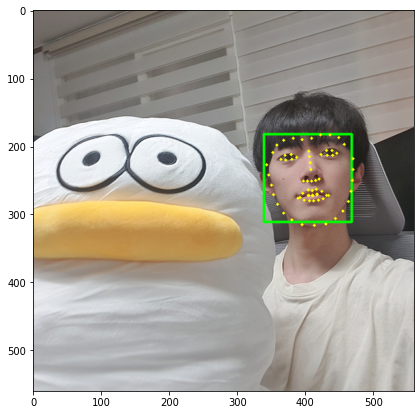

In [28]:
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

스티커를 입히기 직전의 이미지를 불러와봤습니다.

다행히 랜드마크까지만 입혀진 채 무사히 잘 있습니다.

(130, 130, 3)


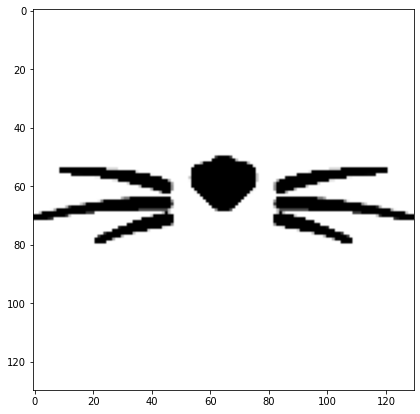

In [29]:
print(img_sticker_resize.shape)
plt.imshow(img_sticker_resize)
plt.show()

스티커는 리사이즈한 스티커부터 시작하겠습니다.

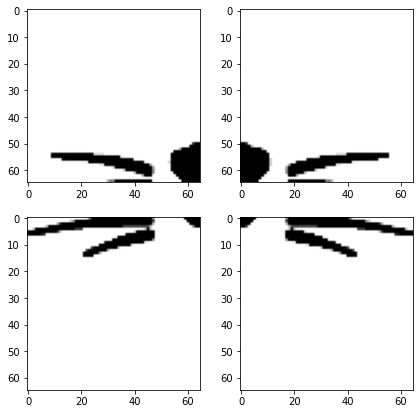

In [30]:
center_x = img_sticker_resize.shape[1]//2
center_y = img_sticker_resize.shape[0]//2

image_parts = [
    img_sticker_resize[:center_y, :center_x], # 4분할 왼쪽 위
    img_sticker_resize[:center_y, center_x:], # 4분할 오른쪽 위
    img_sticker_resize[center_y:, :center_x], # 4분할 왼쪽 아래
    img_sticker_resize[center_y:, center_x:]  # 4분할 오른쪽 아래
]

for i, img in enumerate(image_parts):
    plt.subplot(2, 2, i+1)
    plt.imshow(img)

plt.show()

~~고양이 수염 사지절단!!~~

스티커를 4분할 해줬습니다.

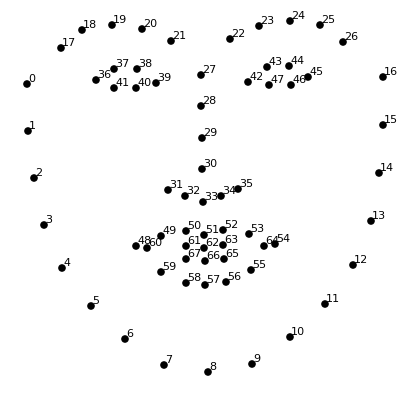

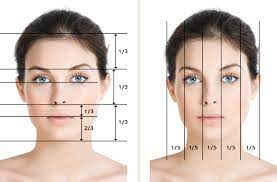

각도를 확인하려면 코가 어느 위치에 있어야 하는지 알 필요가 있습니다.

검색을 통해 가져온 이미지에 의하면 코 끝이 턱과 눈썹 높이의 중간이 가장 이상적이라고 합니다.

마침 랜드마크도 턱과 눈썹까지 확인되므로 턱과 양 옆 눈썹 평균 사이의 중간이 정면상의 코의 높이라고 판단하고

얼굴의 입체적인 변화를 확인하기 좋은 가장 튀어나와있는 코 부분이 그보다 높거나 낮으면 생기는 차이 만큼 스티커의 세로 크기를 줄여주겠습니다.

In [31]:
face_top = (face[19].y + face[24].y) // 2
face_bottom = face[8].y
face_middle = (face_top + face_bottom) // 2

print(face_middle)
print(face[30])

251
(408, 234)


이상적인 코의 y좌표는 251이지만 제 코의 y좌표는 234에 위치합니다.

기울어진 각도를 계산해보겠습니다.

In [32]:
h_angle = 1 - abs(face[30].y - face_middle) / h
h_angle

0.8692307692307693

제 얼굴은 위아래로 0.86만큼 틀어져있다고 볼 수 있겠습니다. (저만의 근거입니다.)

> 각도를 구하는 기준이 마음에 들지 않으면 상수로 조정할 수 있습니다.

(56, 65, 3)


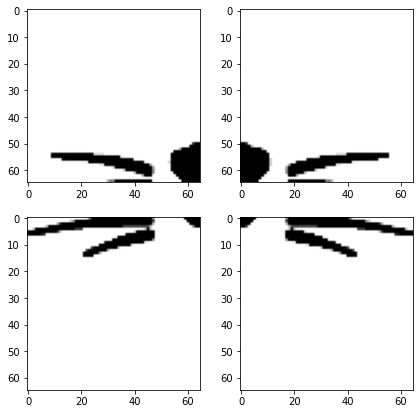

In [33]:
for i, img in enumerate(image_parts):
    image_parts[i] = cv2.resize(img, (img.shape[1], round(img.shape[0] * h_angle)))
    plt.subplot(2, 2, i+1)
    plt.imshow(img)

print(image_parts[0].shape)
plt.show()

예상대로 별 차이는 없군요. 원하던 결과입니다.

코의 양 옆 각도도 중요합니다.

제가 원하는 그림은 정면(왼쪽과 오른쪽의 비율이 1:1)으로 봤을 때 조정이 거의 되지 않은 본래의 사이즈를 보여주면서

옆을 보면 양 쪽의 사이즈가 줄어드는 대신 원근법에 의해 비율이 더 낮은 쪽의 스티커가 더 작게 줄어드는 모습을 원합니다.

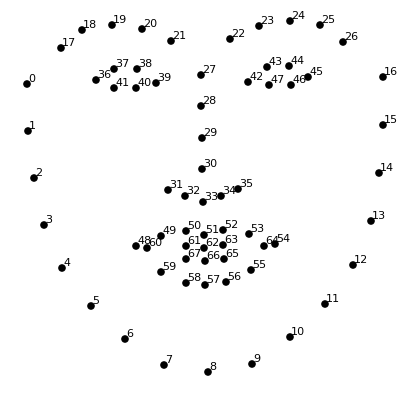

옆의 각도를 보는 기준은 코의 가장 튀어나와있는 부분 30과 그의 양 옆 끝인 2, 14를 사용하겠습니다.

In [34]:
face_width = face[14].x - face[2].x
face_left = (face[30].x - face[2].x) / face_width
face_right = (face[14].x - face[30].x) / face_width

print(face_left)
print(face_right)

0.48739495798319327
0.5126050420168067


왼쪽 뺨의 비율은 0.48이고 오른쪽 뺨의 비율은 0.51입니다. (이번 건 나름 자신있는 근거입니다.)

그런데 양 옆 비율은 그대로 곱해버리면 정면 기준으로도 반토막이 되버리는데다가, 제가 원하는 원근법을 표현하지 못합니다.

원근법에 의해 비율이 많은 쪽이 덜 줄어들도록 만들어 주는 것이 핵심입니다.

In [35]:
perspective_ratio = lambda x: 1 - abs(np.exp(0.5 - x)-1)

print(perspective_ratio(0.3))
print(perspective_ratio(0.7))

0.7785972418398301
0.8187307530779819


`np.exp`를 활용해 직접 만들어본 함수입니다. ~~당연히 뚝딱 만들어진 것은 아닙니다.~~

비율 0.3을 받았을 때 0.77, 비율 0.7을 받았을 때 0.81을 반환했습니다.

변화량은 상수로 제어해줄 수 있지만 일단 이대로 했을 때 제가 원하는 그림이 나와줄지 궁금하군요.

> 비율 0.5를 받으면 1을 반환합니다.

(56, 64, 3)
(56, 64, 3)


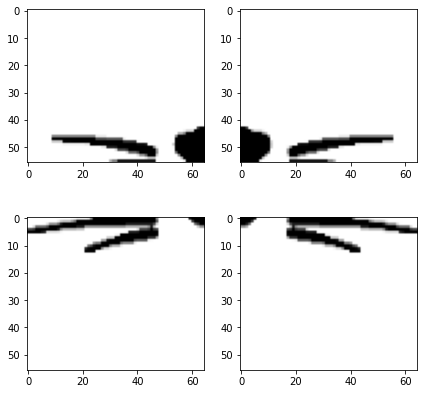

In [36]:
face_left = perspective_ratio(face_left)
face_right = perspective_ratio(face_right)

for i, img in enumerate(image_parts):
    if i % 2 == 0:  # 왼쪽에 해당하는 스티커
        image_parts[i] = cv2.resize(img, (round(img.shape[1] * face_left), img.shape[0]))
    else:           # 오른쪽에 해당하는 스티커
        image_parts[i] = cv2.resize(img, (round(img.shape[1] * face_right), img.shape[0]))
    plt.subplot(2, 2, i+1)
    plt.imshow(img)

print(image_parts[0].shape)
print(image_parts[1].shape)
plt.show()

왼쪽 수염의 사이즈가 65에서 64로 1만큼 줄어들었습니다.

나름 정면이었으니까 역시 예상하고 원했던 결과입니다.

이제 본격적으로 4분할 스티커를 얼굴에 씌워보겠습니다. 얼마 안남았습니다.

In [37]:
y = (face[30].y + face[33].y) // 2

print(x, y)

409 242


`x`와 `y`는 이전에 할당했던 코 끝(랜드마크[33])의 좌표입니다.

하지만 고양이 수염이 들어가는 위치는 30과 33의 중간이였으면 좋겠다 싶어서 y값을 조금 수정했습니다.

In [38]:
sticker_refined = {}

sticker_refined[0] = (x - image_parts[0].shape[1], y - image_parts[0].shape[0]) # 왼쪽 위 부분의 시작점
sticker_refined[1] = (x, y - image_parts[1].shape[0])                           # 오른쪽 위 부분의 시작점
sticker_refined[2] = (x - image_parts[2].shape[1], y)                           # 왼쪽 아래 부분의 시작점
sticker_refined[3] = (x, y)                                                     # 오른쪽 아래 부분의 시작점

sticker_refined

{0: (345, 186), 1: (409, 186), 2: (345, 242), 3: (409, 242)}

분할된 스티커의 각 시작점을 어떻게 관리하면 좋을까 고민하다가 딕셔너리에 저장하기로 했습니다.

In [39]:
def refined(img, sticker, index):

    min_x = sticker_refined[index][0]
    min_y = sticker_refined[index][1]
    max_x = min_x + sticker.shape[1]
    max_y = min_y + sticker.shape[0]
    right = img.shape[1]
    bottom = img.shape[0]

    if min_x < 0: 
        sticker = sticker[:, -min_x:]
        min_x = 0
    if max_x > right:
        sticker = sticker[:, :right-max_x]
        max_x = right
    if min_y < 0:
        sticker = sticker[-min_y:, :]
        min_y = 0
    if max_y > bottom:
        sticker = sticker[:bottom-max_y, :]
        max_y = bottom

    return sticker, min_x, max_x, min_y, max_y

스티커가 이미지 바깥으로 나가는지를 관리해주는 함수를 만들어줬습니다.

이전 방법에서 스티커 좌표가 이미지 사이즈보다 클 경우 잘라내기를 추가해줬습니다.

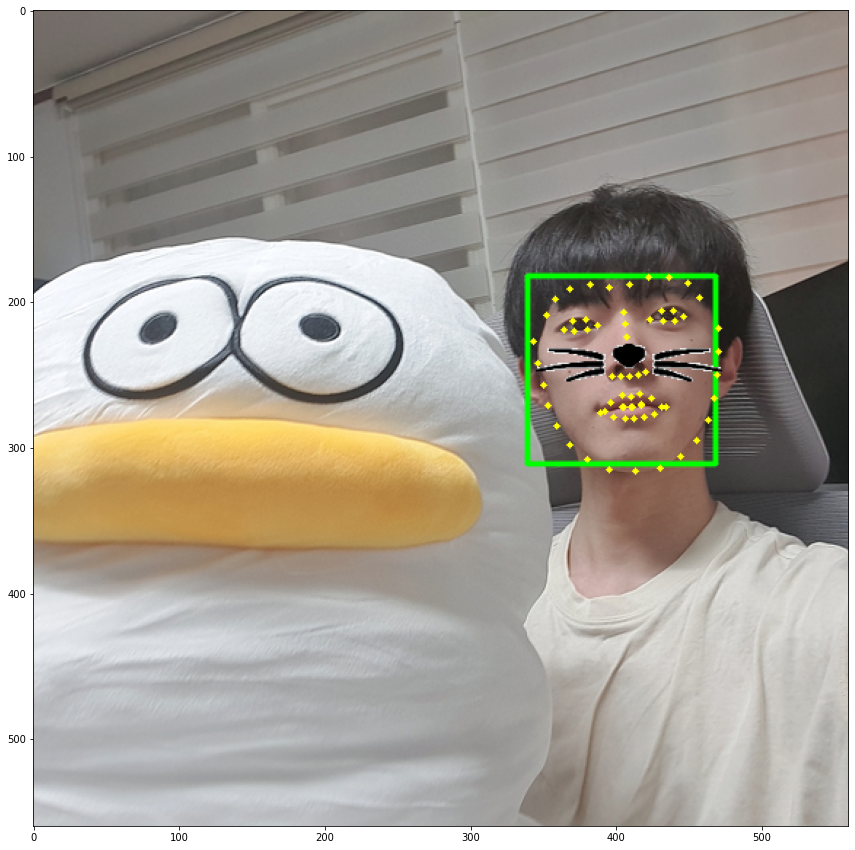

In [40]:
for i, img in enumerate(image_parts):
    sticker, min_x, max_x, min_y, max_y = refined(img_show, img, i) # 이미지 바깥 부분 자르기
    sticker_area = img_show[min_y:max_y, min_x:max_x]               # 이미지에서 스티커가 적용될 부분
    img_show[min_y:max_y, min_x:max_x] = np.where(sticker==255, sticker_area, sticker).astype(np.uint8) # 스티커 적용용

plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

비록 각도에 따른 결과물은 확인할 수 없었지만 무사히 잘 적용됐습니다.

지금까지의 과정을 하나로 묶어 이미지와 스티커를 인자로 받으면 이미지의 얼굴에 스티커를 합성해주는 함수를 만들고

얼굴이 없거나 여러 개 또는 사이즈가 이미지 밖으로 나가거나 옆모슾을 촬영한 경우를 준비하고 스티커를 합성해보도록 하겠습니다.

- - -
### 4. 스티커 적용 함수 만들기

In [41]:
def sticker_divide(sticker): # 스티커를 4분할 해주는 함수
    center_x = sticker.shape[1]//2
    center_y = sticker.shape[0]//2

    sticker_parts = [
        sticker[:center_y, :center_x], # 4분할 왼쪽 위
        sticker[:center_y, center_x:], # 4분할 오른쪽 위
        sticker[center_y:, :center_x], # 4분할 왼쪽 아래
        sticker[center_y:, center_x:]  # 4분할 오른쪽 아래
    ]

    return sticker_parts

PERSPECTIVE_SCALE = 1.0

def perspective_ratio(x): # 양 옆 비율에 원근법을 적용해주는 함수
    x = 1 - abs((np.exp(0.5 - x)-1)*PERSPECTIVE_SCALE) # PERSPECTIVE_SCALE을 상수로 받아 각도에 의해 줄어드는 정도를 조절
    return x

def sticker_scaling(sticker, points, w, h): # 코의 위치를 기준으로 얼굴의 상하좌우 각도에 따라 스티커를 리사이즈 해주는 함수
    face_top = (points[19].y + points[24].y) // 2
    face_bottom = points[8].y
    face_middle = (face_top + face_bottom) // 2
    h_angle = 1 - abs(points[30].y - face_middle) / h
    print(f'height ratio : {h_angle}')

    face_width = points[14].x - points[2].x
    face_left = (points[30].x - points[2].x) / face_width
    face_right = (points[14].x - points[30].x) / face_width
    l_angle = perspective_ratio(face_left)
    r_angle = perspective_ratio(face_right)
    print(f'left ratio : {face_left}', f'right ratio : {face_right}')

    for i, img in enumerate(sticker):
        if i % 2 == 0:
            sticker[i] = cv2.resize(img, (round(img.shape[1] * l_angle), round(img.shape[0] * h_angle)))
        else:
            sticker[i] = cv2.resize(img, (round(img.shape[1] * r_angle), round(img.shape[0] * h_angle)))

    return sticker
    
def starting_points(sticker, points): # 4분할 스티커의 각 시작점 좌표를 딕셔너리로 반환해주는 함수
    x = points[30].x
    y = (points[30].y + points[33].y) // 2

    sticker_refined = {}

    sticker_refined[0] = (x - sticker[0].shape[1], y - sticker[0].shape[0])
    sticker_refined[1] = (x, y - sticker[1].shape[0])
    sticker_refined[2] = (x - sticker[2].shape[1], y)
    sticker_refined[3] = (x, y)

    return sticker_refined

def size_fit(size, sticker, min_x, min_y, max_x, max_y): # 스티커가 이미지 밖으로 벗어나는 부분을 제거해 오류를 방지하는 함수
    right = size[1]
    bottom = size[0]

    if min_x < 0:
        sticker = sticker[:, -min_x:]
        min_x = 0
    if max_x > right:
        sticker = sticker[:, :right-max_x]
        max_x = right
    if min_y < 0:
        sticker = sticker[-min_y:, :]
        min_y = 0
    if max_y > bottom:
        sticker = sticker[:bottom-max_y, :]
        max_y = bottom

    return sticker, min_x, min_y, max_x, max_y

def nose_sticker(img, sticker, w_scale=1, h_scale=1):
    '''
    이미지의 코에 스티커를 합성해주는 메인 함수
    코에 합성하는 스티커들만 활용할 수 있으니 nose_sticker라는 이름을 붙여주겠습니다.
    '''
    dlib_rects = detector_hog(img, 1)

    if not dlib_rects: # 사진에 얼굴이 없을 경우 return
        print('얼굴이 인식되지 않습니다.')
        return
    

    for dlib_rect in dlib_rects:
        sticker_copy = sticker.copy() # 스티커 사본을 사용해서 원본은 남겨둠
        points = landmark_predictor(img, dlib_rect).parts() # 랜드마크 좌표 생성
        sticker_copy = cv2.resize(sticker_copy, (round(dlib_rect.width()*w_scale), round(dlib_rect.height()*h_scale))) # 스티커 리사이즈, scale을 인자로 받아서 크기 비율을 설정할 수 있음

        sticker_parts = sticker_divide(sticker_copy) # 스티커 4분할
        sticker_parts = sticker_scaling(sticker_parts, points, dlib_rect.width(), dlib_rect.height()) # 스티커 각도 비율 조정

        sticker_refined = starting_points(sticker_parts, points) # 4분할 스티커 각 시작점 좌표 출력

        for i, parts in enumerate(sticker_parts):
            parts, min_x, min_y, max_x, max_y = size_fit( # 이미지 바깥 부분은 자르기
                img.shape, 
                parts, 
                sticker_refined[i][0], 
                sticker_refined[i][1], 
                sticker_refined[i][0] + parts.shape[1], 
                sticker_refined[i][1] + parts.shape[0]
            )
            sticker_area = img[min_y:max_y, min_x:max_x]
            img[min_y:max_y, min_x:max_x] = np.where(parts==255, sticker_area, parts).astype(np.uint8) # 스티커 적용
        print('=================================================================')

    plt.imshow(img)
    plt.show()

함수가 완성됐습니다.

이미지와 스티커만 준비해주고 `nose_sticker` 함수만 출력해주면 스티커 합성이 완료됩니다.

바로 확인해보죠.

height ratio : 0.8692307692307693
left ratio : 0.48739495798319327 right ratio : 0.5126050420168067


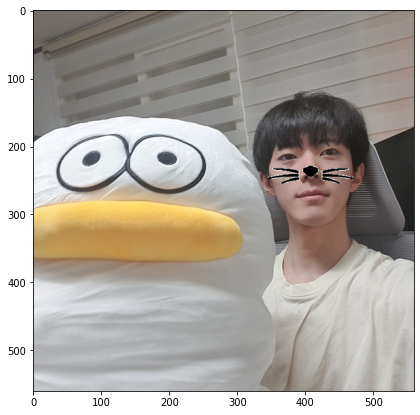

In [42]:
img_sample = img_rgb.copy()

nose_sticker(img_sample, img_sticker)

성공적으로 잘 합성됐습니다. ~~사실 한 번에 성공했을 리는 없죠.~~

저는 메인 함수에 scale 인자도 만들었는데요. 잘 작동하나 확인해보겠습니다.

height ratio : 0.8692307692307693
left ratio : 0.48739495798319327 right ratio : 0.5126050420168067


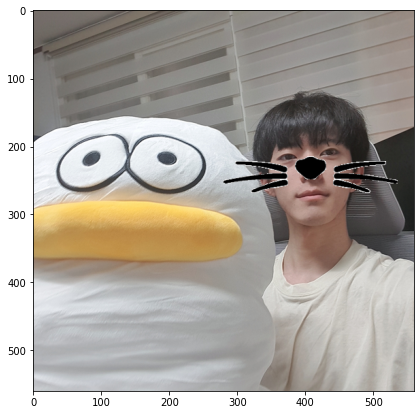

In [43]:
img_sample = img_rgb.copy()

nose_sticker(img_sample, img_sticker, w_scale=2, h_scale=2)

가로와 세로를 2배로 늘려봤습니다. 잘 작동되는 것 같습니다.

사이즈를 줄여도 보겠습니다.

height ratio : 0.8692307692307693
left ratio : 0.48739495798319327 right ratio : 0.5126050420168067


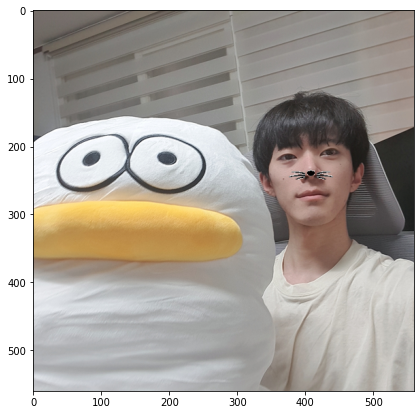

In [44]:
img_sample = img_rgb.copy()

nose_sticker(img_sample, img_sticker, w_scale=0.5, h_scale=0.5)

줄이는 것도 잘 작동되는군요.

슬슬 다른 이미지도 불러와서 본격적으로 실험해볼까요.

height ratio : 0.6602564102564102
left ratio : 0.4539877300613497 right ratio : 0.5460122699386503


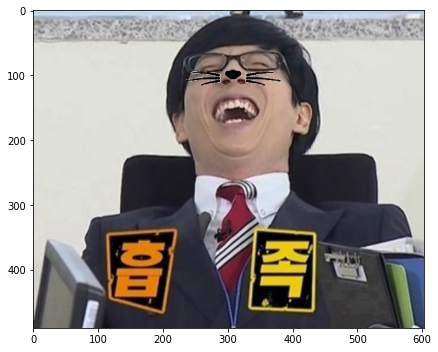

In [45]:
my_image_path = '/content/drive/MyDrive/Colab Notebooks/exp/Pictures/you.png'
img_sample = cv2.imread(my_image_path)
img_sample = cv2.cvtColor(img_sample, cv2.COLOR_BGR2RGB)

nose_sticker(img_sample, img_sticker)

상하 비율이 0.66인 얼굴 이미지입니다.

스티커가 비율에 맞게 잘 들어가다 못해 너무 자연스러워서 원래 이미지인 것 같습니다.

height ratio : 0.9572192513368984
left ratio : 0.8666666666666667 right ratio : 0.13333333333333333
height ratio : 1.0
left ratio : 0.5454545454545454 right ratio : 0.45454545454545453


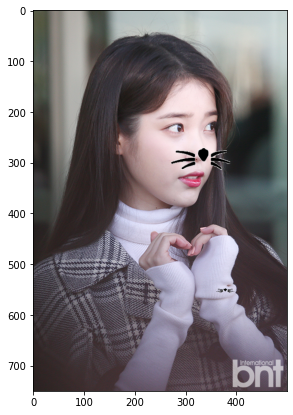

In [46]:
my_image_path = '/content/drive/MyDrive/Colab Notebooks/exp/Pictures/44ce7571842afebe24763aba74a78ca2.png'
img_sample = cv2.imread(my_image_path)
img_sample = cv2.cvtColor(img_sample, cv2.COLOR_BGR2RGB)

nose_sticker(img_sample, img_sticker)

살짝 옆모습의 이미지입니다.

비율이 0.86:0.13인데 양 옆의 차이가 생각보다 크게 나지 않으면서 수염이 너무 짧아진 것 같습니다.

만들어뒀던 스케일 조정 상수와 함께 가로 스케일을 늘려보겠습니다.

    소매에 있는 얼굴은 무엇?

height ratio : 0.9572192513368984
left ratio : 0.8666666666666667 right ratio : 0.13333333333333333
height ratio : 1.0
left ratio : 0.5454545454545454 right ratio : 0.45454545454545453


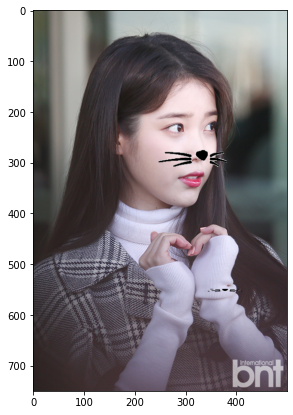

In [47]:
PERSPECTIVE_SCALE = 1.7

img_sample = cv2.imread(my_image_path)
img_sample = cv2.cvtColor(img_sample, cv2.COLOR_BGR2RGB)

nose_sticker(img_sample, img_sticker, w_scale=2, h_scale=0.8)

비율 상수를 1.7로, 가로 스케일을 2로 설정하니 원근법이 나름 괜찮게 적용된 것 같습니다.

사실 옆모습 이미지를 적용할 때마다 이렇게 일일이 스케일 조정이 필요하다면 실용적이지는 못하겠죠.

원인은 비율이 큰 곳과 작은 곳이 서로 차이가 크게 나지 않고 많이 줄어든다는 건데

1:1 비율 값인 0.5를 뺐을 때 조건문으로 음수와 양수 각각 다르게 적용하면 원하는 대로 가능했지만 최대한 자연스러운 코드를 원했습니다.

height ratio : 0.9782608695652174
left ratio : 0.5223880597014925 right ratio : 0.47761194029850745


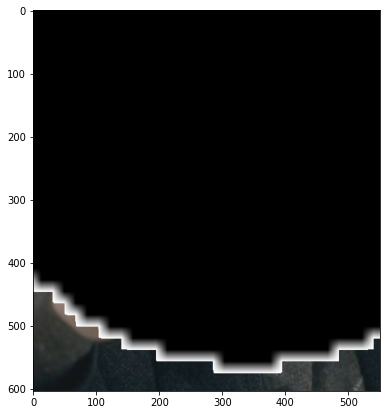

In [48]:
my_image_path = '/content/drive/MyDrive/Colab Notebooks/exp/Pictures/zzal.jpg'
img_sample = cv2.imread(my_image_path)
img_sample = cv2.cvtColor(img_sample, cv2.COLOR_BGR2RGB)

nose_sticker(img_sample, img_sticker, w_scale=30, h_scale=30)

스티커가 이미지 바깥으로 나가는 경우입니다. 문제 없이 잘 작동합니다.

고양이 수염 스티커가 정상적으로 이미지 밖으로 나갈 일이 거의 없어

억지로 스케일을 30배로 늘렸습니다.

height ratio : 0.9782608695652174
left ratio : 0.5223880597014925 right ratio : 0.47761194029850745


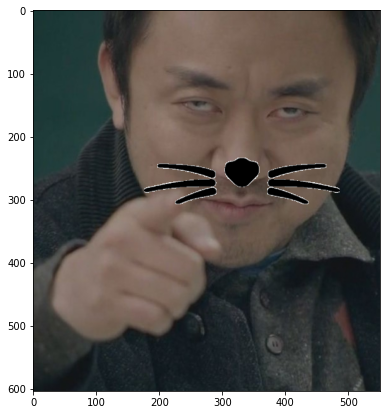

In [49]:
img_sample = cv2.imread(my_image_path)
img_sample = cv2.cvtColor(img_sample, cv2.COLOR_BGR2RGB)

nose_sticker(img_sample, img_sticker)

스티커에 가려졌던 이미지는 마동석이였습니다.

근데 보다보니 고양이 수염보다는 쥐 수염에 더 가까운 느낌이 드는 것은 저뿐일까요.

height ratio : 0.9342105263157895
left ratio : 0.65 right ratio : 0.35


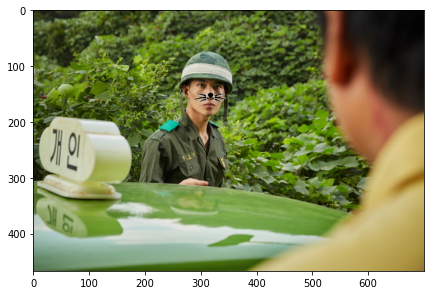

In [50]:
my_image_path = '/content/drive/MyDrive/Colab Notebooks/exp/Pictures/190p215ben4r13u5m999.png'
img_sample = cv2.imread(my_image_path)
img_sample = cv2.cvtColor(img_sample, cv2.COLOR_BGR2RGB)

nose_sticker(img_sample, img_sticker)

멀리 있는 얼굴도 라이브러리가 잘 인식해 무사히 스티커가 합성된 모습입니다.

height ratio : 0.9923076923076923
left ratio : 0.5303030303030303 right ratio : 0.4696969696969697
height ratio : 1.0
left ratio : 0.47761194029850745 right ratio : 0.5223880597014925
height ratio : 0.8538461538461538
left ratio : 0.6099290780141844 right ratio : 0.3900709219858156
height ratio : 0.8384615384615385
left ratio : 0.415929203539823 right ratio : 0.584070796460177


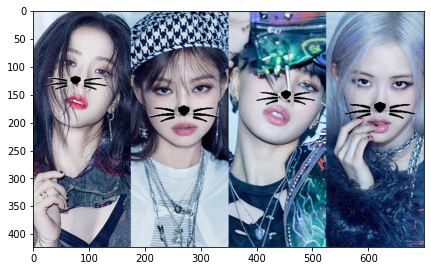

In [51]:
my_image_path = '/content/drive/MyDrive/Colab Notebooks/exp/Pictures/image_readtop_2020_1009922_16015896634373905.png'
img_sample = cv2.imread(my_image_path)
img_sample = cv2.cvtColor(img_sample, cv2.COLOR_BGR2RGB)

nose_sticker(img_sample, img_sticker)

얼굴이 여러 개 있는 이미지입니다.

얼굴이 여러 개 있어도 합성에 문제가 생기지는 않았으나 여기서 문제점을 확인할 수 있습니다.

갸우뚱한 얼굴은 수염이 같이 기울어지지 않는다는 건데요.

함수를 만들면서 이 문제에 대해서도 생각을 해봤는데, 아직 제가 해결할 영역이 아닌 것 같아 배제했습니다.

    맨 왼쪽은 얼굴은 가로 위치도 어긋나 있는데요. 함수에 문제는 없었던 걸 보면 dlib 라이브러리도 만능은 아닌가봅니다.

height ratio : 0.9907407407407407
left ratio : 0.4777777777777778 right ratio : 0.5222222222222223
height ratio : 0.9868421052631579
left ratio : 0.5588235294117647 right ratio : 0.4411764705882353
height ratio : 0.8867924528301887
left ratio : 0.4489795918367347 right ratio : 0.5510204081632653
height ratio : 0.8867924528301887
left ratio : 0.5 right ratio : 0.5
height ratio : 0.945054945054945
left ratio : 0.6235294117647059 right ratio : 0.3764705882352941
height ratio : 0.981651376146789
left ratio : 0.3723404255319149 right ratio : 0.6276595744680851
height ratio : 0.92
left ratio : 0.47058823529411764 right ratio : 0.5294117647058824
height ratio : 0.9605263157894737
left ratio : 0.5 right ratio : 0.5
height ratio : 0.9605263157894737
left ratio : 0.3442622950819672 right ratio : 0.6557377049180327
height ratio : 0.9908256880733946
left ratio : 0.5869565217391305 right ratio : 0.41304347826086957


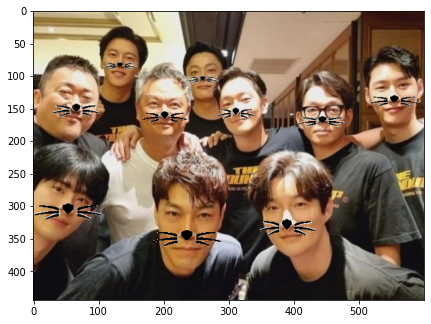

In [52]:
my_image_path = '/content/drive/MyDrive/Colab Notebooks/exp/Pictures/1135368_813469_1424.png'
img_sample = cv2.imread(my_image_path)
img_sample = cv2.cvtColor(img_sample, cv2.COLOR_BGR2RGB)

nose_sticker(img_sample, img_sticker)

4명이 잘 나왔으니 더 많은 얼굴이 있는 이미지를 합성해봤습니다.

모두 무사히 스티커가 합성된 것도 놀라운데 함수 실행이 1초 만에 끝났다는 것도 조금 신기합니다. ~~이것이 코랩의 힘..?~~

마지막으로 얼굴이 없는 이미지를 넣어보고 실험을 마무리하겠습니다.

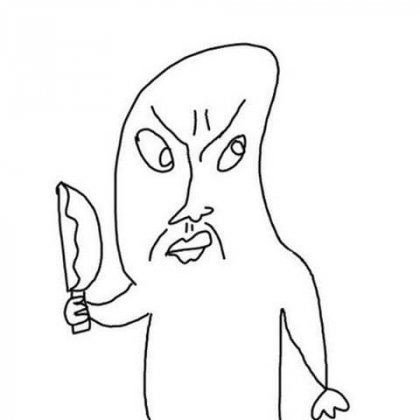

In [53]:
my_image_path = '/content/drive/MyDrive/Colab Notebooks/exp/Pictures/img.jpg'
img_sample = cv2.imread(my_image_path)
img_sample = cv2.cvtColor(img_sample, cv2.COLOR_BGR2RGB)

nose_sticker(img_sample, img_sticker)

얼굴이 인식되지 않습니다.


## 마무리하며

코딩을 독학으로 배우던 때에 ui도 많이 다뤄봤었습니다.

이번 프로젝트는 ui를 다루던 그 때의 느낌이 강하게 들어서 지금까지 작성한 프로젝트 중에 가장 재미있게 작성한 것 같습니다.  
~~그렇다고 아직 cv 쪽으로 마음을 결정한 것은 아닙니다.~~

그래도 역시 전체적으로 감을 잡을 때 까지 예제의 코드를 가져오고, 코드를 하나하나 뜯어보면서 이해하는 식으로 프로젝트를 작성했는데요.

아마 앞으로도 자주 이런 느낌으로 작성하게 될 것 같습니다.

프로젝트를 만들면서 내 프로젝트가 정말 활용된다는 생각으로 욕심을 내면서 만들었던 것 같습니다.

각도 문제를 해결하는 것 뿐만이 아닌 여러 가지 문제를 상정하고 대응하도록 준비하고

코에 넣는 스티커라면 고양이 수염이 아니여도 적용할 수 있도록 함수를 설계하고고

코에 넣지 않더라도 함수를 조금만 수정하면 어느 부위에든 넣을 수 있도록 접근성에 신경을 많이 썼습니다.

마지막까지 해결하지 못한 부분은 고개를 갸우뚱 했을 때 스티커도 같이 기울여주는 것인데요.

이론은 상상이 갔으나 그 마저도 너무 복잡하고 생소한 계산식을 사용해야 할 것 같아서 결국 시작할 엄두는 내지 못했습니다.

나중에 제가 더 배우고 와서 지금 이 프로젝트가 생각이 난다면 아마 부담없이 다시 도전해보겠죠.

지금 이 정도만 해도 각도를 어떻게 계산해야 좋을까 스티커 합성에 방해되는 상황은 어떤 것들이 있을까 생각하고 고민하는 시간이 정말 많이 소모됐고

주말을 거의 붙잡고 있어야 프로젝트를 완성하는 속도였지만 결과물을 보면 또 뿌듯하고 만족스럽습니다.